# Install Requirements

In [1]:
%pip install transformers datasets
%pip install torch
%pip install matplotlib
%pip install umap-learn numba==0.48.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached numba-0.48.0.tar.gz (2.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached llvmlite-0.31.0.tar.gz (110 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.2.tar.gz (86 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.1.tar.gz (80 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap-learn-0.5.0.tar.gz (81 kB)
  Preparing metadata (setup.py) ... done
  Using cached umap_learn-0.4.6-py3-none-any.whl
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [755 lines of output]
      /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-install-9w3wjdjf/numba_3ce053275a9a4ba3b8428433db27acbd/setup.py:98: DeprecationWarning:
      
        `

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load Language Model

In [3]:
#MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled" # NL MODEL TODO: is the model trained on lowercased data?

MODEL_NAME = "roberta-base"

#MODEL_NAME = "xlm-roberta-base" # cross-lingual mode (https://huggingface.co/xlm-roberta-base)


In [4]:
from transformers import RobertaModel, AutoTokenizer, RobertaPreTrainedModel, BertModel, GPT2Model, pipeline
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
#model = RobertaModel.from_pretrained(MODEL_NAME)

# FIXME: cannot use pipeline for extracting layers other than the last one
model: FeatureExtractionPipeline = pipeline('feature-extraction', model=MODEL_NAME, tokenizer=tokenizer)

/Users/carstenschnober/opt/anaconda3/envs/SoS/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Load Data

In [5]:
from pathlib import Path

DATA_DIR = Path.cwd() / "data"

## SemEval 2020 (C)COHA corpus

### Download

In [6]:
from io import BytesIO
from zipfile import ZipFile
import urllib

SEMEVAL_DATA_URL = "https://www2.ims.uni-stuttgart.de/data/sem-eval-ulscd/semeval2020_ulscd_eng.zip"

SEMEVAL2020_DIR = DATA_DIR / "semeval2020_ulscd_eng"

if SEMEVAL2020_DIR.is_dir():
    print(f"Directory '{SEMEVAL2020_DIR}' already exists, skipping corpus download.")
else:
    with urllib.request.urlopen(SEMEVAL_DATA_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(DATA_DIR)

assert SEMEVAL2020_DIR.is_dir(), f"Directory does not exist: '{SEMEVAL2020_DIR}'"


Directory '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/semeval2020_ulscd_eng' already exists, skipping corpus download.


In [7]:
CORPUS1_DIR = SEMEVAL2020_DIR / 'corpus1'
CORPUS2_DIR = SEMEVAL2020_DIR / 'corpus2'
TRUTH_DIR = SEMEVAL2020_DIR / 'truth'

assert CORPUS1_DIR.is_dir(), f"Directory does not exist: '{CORPUS1_DIR}'"
assert CORPUS2_DIR.is_dir(), f"Directory does not exist: '{CORPUS2_DIR}'"
assert TRUTH_DIR.is_dir(), f"Directory does not exist: '{TRUTH_DIR}'"


### Read

In [8]:
TOKENS_FILE1 = CORPUS1_DIR / "token" / "ccoha1.txt.gz"
TOKENS_FILE2 = CORPUS2_DIR / "token" / "ccoha2.txt.gz"

assert TOKENS_FILE1.is_file()
assert TOKENS_FILE2.is_file()

In [9]:
import gzip

with gzip.open(TOKENS_FILE1, 'rt') as f:
    sentences_1810 = f.readlines()

assert len(sentences_1810) == 253644

with gzip.open(TOKENS_FILE2, 'rt') as f:
    sentences_1960 = f.readlines()

assert len(sentences_1960) == 353692

## COHA Corpus (Sample)

### Download

In [10]:
#COHA_DATABASE_URL = 'https://www.corpusdata.org/coha/samples/database.zip'
COHA_TEXT_URL = 'https://www.corpusdata.org/coha/samples/text.zip'

COHA_DIR = DATA_DIR / "COHA"

try:
    COHA_DIR.mkdir(parents=True, exist_ok=False)
except OSError as e:
    print(f"Directory '{COHA_DIR}' already exists: {str(e)}. Skipping corpus download.")
else:
    with urllib.request.urlopen(COHA_TEXT_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(COHA_DIR)

assert COHA_DIR.is_dir()

Directory '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/COHA' already exists: [Errno 17] File exists: '/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/ContextualLM/data/COHA'. Skipping corpus download.


### Read

In [11]:
from functools import cached_property
import logging
import re
from typing import Generator, List

FILENAME_PATTERN = r"([a-z]{2,4})_(\d{4})_(\d{3,6})\.txt"
SENTENCE_PATTERN = r"\s*(.*?\s[\.!?\n])"

class CohaDoc:
    _encoding = 'UTF-8'

    def __init__(self, path: Path):
        self._path = path

        try:
            genre, year, id = re.search(FILENAME_PATTERN, self._path.name).groups()
        except AttributeError as e:
            raise ValueError(f"Could not parse path: '{path}': {str(e)}")
        
        self._genre = genre
        self._year = int(year)
        self._id = int(id)

    def __repr__(self) -> str:
        return str(self._path.name)

    @property
    def genre(self) -> str:
        return self._genre

    @property
    def year(self) -> int:
        return self._year

    @property
    def id(self) -> int:
        return self._id
    
    @cached_property
    def text(self):
        with open(self._path, 'rt', encoding=self._encoding) as f:
            return f.read()

    def sentences(self):
        sentences = re.findall(SENTENCE_PATTERN, self.text)
        assert sentences[0].strip() == f"@@{self._id}", f"First line is expected to match document ID ('{self._id}'), but is: {sentences[0]}"
        return sentences[1:]

    def find_sentences(self, term: str) -> List[str]:
        return [
            sentence
            for sentence in self.sentences()
            if term in sentence
        ]
        
    def clean_sentences(self):
        # TODO
        return NotImplemented


In [12]:
coha_docs = [CohaDoc(file) for file in COHA_DIR.glob('*.txt')]

assert len(coha_docs) == 1144

(array([ 12.,  13.,  24.,  50.,  60., 156., 206., 188., 247., 188.]),
 array([1817. , 1836.2, 1855.4, 1874.6, 1893.8, 1913. , 1932.2, 1951.4,
        1970.6, 1989.8, 2009. ]),
 <BarContainer object of 10 artists>)

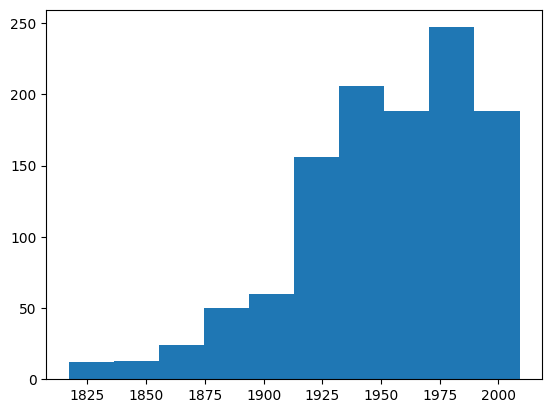

In [13]:
plt.hist([c.year for c in coha_docs])

(array([586.,   0.,   0., 424.,   0.,   0., 108.,   0.,   0.,  26.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

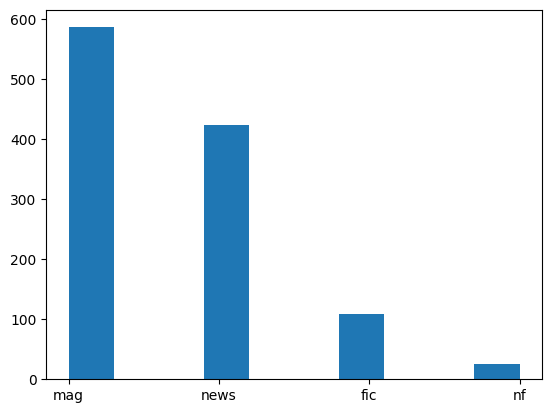

In [14]:
plt.hist([c.genre for c in coha_docs])

# Embeddings

## COHA

In [15]:
TERM1 = 'Amsterdam'
TERM2 = 'America'

In [16]:

from tqdm import tqdm


for doc in tqdm(coha_docs, unit='doc'):
    if matches := doc.find_sentences(TERM1):
        print(doc)
        print(matches)


  4%|▍         | 44/1144 [00:00<00:05, 193.57doc/s]

fic_1979_10650.txt
['They had agreed to be philosophicalabout their baggage  --  Air France could keep it for them in Amsterdam , hopefully under lock and key  --  you could hardly expect hijackers to be interested in whether you had your nighties or clean shirts .', 'He was touched by it in a way , remembering himself when he had first come to Amsterdam as an apprentice electricianand looked with wonder at @ @ @ @ @ @ @ @ @ @ the Rijksmuseum .', 'The manipulative hand of some firm of Amsterdam architects  --  planners for @ @ @ @ @ @ @ @ @ @ , where the new television throned and a stack of religious newspapers seemed to wait for banishment .', 'Early Sunday morning , Elfride and Horst had arrived at the farmhouse in the by-now-familiar truck , explaining that the Dutch crew would follow : they had been held up in Amsterdam by trouble with one of the cameras ; probably the family would cross them on the road .', 'In his young days in Amsterdam , when the word " waarde " had sounded in

 37%|███▋      | 426/1144 [00:00<00:01, 625.24doc/s]

mag_1945_158950.txt
['<P> Last week , while awaiting trial in an Amsterdam jail ( for collaboration with the Nazis ) , van Meegeren was under close watch by the art experts themselves , whose own prestige was involved .', 'From the profits of his " discovered Vermeers " he moved into an Amsterdam mansion .']
mag_1998_400150.txt
['// Another Taufschein artist , Anton Rehm , arrived in Philadelphia from Amsterdam about 1816 .']


 49%|████▉     | 560/1144 [00:01<00:01, 571.82doc/s]

mag_1965_492050.txt
['The first rehearsals took place in an old theater on the seventh floor of the New Amsterdam movie house at Broadway and 42nd Street .', 'The scene was nearly identical to the one on the Amsterdam Roof : steam pipes against a brick wall behind the stage , the same harsh light @ @ @ @ @ @ @ @ @ @ month of rehearsals , had become bored .', '1 : URI billboard pntilica y for 1611y. lie had been wail the production since the beginning at the Amsterdam Root Although never fond Of the play , he liked many of the people associated with it .']
news_1940_705050.txt
['A flier assigned to help blast this plant dropped only one " stick " of high explosives , then flew to Amsterdam , where he released the rest of his destructive cargo on the famous Fokker airplane works .']
mag_1821_553350.txt
['From various sources he collected a sufficient sum to pay his expenses to Amsterdam , and trusting in Providence for the means of continuing his journey after he should arrive there , he

 64%|██████▍   | 733/1144 [00:01<00:00, 550.73doc/s]

news_1973_730850.txt
['The American currency set new lows in Frankfurt , Paris , Zurich , Amsterdam , Brussels , Oslo , Milan , and Stockholm .']
mag_1928_164350.txt
['Amsterdam is the city of drab workmen who cut and polish brightest diamonds , the home of landlubbing watermen who pole barges along slow canals , the habitat of buxom and sensible stenographers who pedal to work each morning upon thousands of bicycles .', 'Amsterdam , in short , is the last place where one would expect to hear-during the decent forenoon hours , and from a stately mansion-a sequence of revolver shots .', 'In Amsterdam the buzz of tickers ceased to have meaning , last week , for Mevrouw Van Eeghen .']
fic_1919_1550.txt
['" " Babies , " she replies demurely ; " two babies from Amsterdam .', 'So the Amsterdam committee has sent them here .', '" By all the gods , da  --  those Amsterdammers !']
news_1931_698050.txt
['This brings the London rate high aboire Paris , Amsterdam , Zurich , New York or Brussels , 

 80%|███████▉  | 915/1144 [00:01<00:00, 539.44doc/s]

news_1907_781050.txt
['Accompanied by his wife , Miss May Frick of Baltimore , and a second guest , a man , Mr. Varnum started last night from his home , at 36 East Fifty-second Street , in his limousine car for the New Amsterdam Theatre .']


 92%|█████████▏| 1050/1144 [00:02<00:00, 478.10doc/s]

nf_1909_774350.txt
['Some years ago the city of Amsterdam found that the Zuider Zee had become too shallow to accommodate ocean vessels , and the city was threatened with the loss of its ocean commerce .', 'This waterway has assured Amsterdam continued growth and prosperity .']
mag_1957_132450.txt
['" // He moved up on through the Yankee chain , playing at Norfolk and Amsterdam of the Canadian-American League in \' 47 , Quincy of the Three-Eye League in \' 48 and Kansas City in \' 49-50 .']
news_1908_677950.txt
['500 shares of the New Amsterdam National Bank , and , 100 shares of Garfield National Bank stock .']


100%|██████████| 1144/1144 [00:02<00:00, 518.83doc/s]


# Embeddings

In [17]:
import collections
from dataclasses import dataclass
from functools import cache
from itertools import islice
from typing import Iterable, List, Optional, Tuple
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline

def sliding_window(iterable, n):
    # From https://docs.python.org/3/library/itertools.html#itertools-recipes
    # sliding_window('ABCDEFG', 4) --> ABCD BCDE CDEF DEFG
    it = iter(iterable)
    window = collections.deque(islice(it, n), maxlen=n)
    if len(window) == n:
        yield tuple(window)
    for x in it:
        window.append(x)
        yield tuple(window)


@dataclass
class Sentence:
    text: str
    coha_doc: CohaDoc
    model: FeatureExtractionPipeline

    def __contains__(self, s: str):
        return s in self.text

    @property
    def year(self) -> Optional[int]:
        return self.coha_doc.year

    @property
    def tokenizer(self):
        return self.model.tokenizer

    @cached_property
    def _embeddings(self):
        return self.model(self.text)[0]

    @cached_property
    def _token_ids(self):
        return self.tokenizer(self.text)['input_ids']

    def embeddings_matrix(self, token: str) -> List[np.array]:
        return [
                self._aggregate_embeddings(token_i, token_length)
                for token_i, token_length in self._find_token(token, self._token_ids)
            ]

    @staticmethod    
    def _find_token(token: str, token_ids: List[int], max_n: int = 5) -> Tuple[int, int]:
        """
        Find sequences of (sub-word) tokens that match a (word) token if merged

        Args:
            - token: a token (word) to find, exact match
            - token_ids: a sequence of token ids generated by a transformer tokenizer
            - max_n: the maximum number of sub-word tokens to be merged
        Yields: Tuple[int, int]: the token index and the length (number of tokens to be merged)
        """
        _tokens = model.tokenizer.convert_ids_to_tokens(token_ids)

        for n in range(max_n, 0, -1):
            for i, window in enumerate(sliding_window(_tokens, n)):
                _token = model.tokenizer.convert_tokens_to_string(window)
                if _token.strip() == token:
                    yield i, n

    def _aggregate_embeddings(self, token_start_index: int, token_length: int) -> np.array:
        if token_length == 1:
            return np.array(self._embeddings[token_start_index])
        else:
            return np.array(self._embeddings[token_start_index:token_start_index+token_length]).mean(axis=0)



In [18]:
import random

random.seed(0)

doc = random.choice(coha_docs)
s = random.choice(doc.sentences())

sentence = Sentence(s, doc, model)
print(sentence)

Sentence(text='He had had little involvement in politics and avoided the public spotlight , preferring instead to spend his free time tending the roses at his country home southwest of Paris .', coha_doc=mag_1986_333750.txt, model=<transformers.pipelines.feature_extraction.FeatureExtractionPipeline object at 0x7f9cb13f59c0>)


In [19]:
np.array(sentence.embeddings_matrix('the')).shape

(2, 768)

In [20]:
from tqdm import tqdm

term1_sentences: List[Sentence] = [
    Sentence(s, doc, model)
    for doc in tqdm(coha_docs, unit='doc')
    for s in doc.find_sentences(TERM1)
]

100%|██████████| 1144/1144 [00:00<00:00, 1573.32doc/s]


In [21]:
from tqdm import tqdm

term2_sentences: List[Sentence] = [
    Sentence(s, doc, model)
    for doc in tqdm(coha_docs, unit='doc')
    for s in doc.find_sentences(TERM2)
]

100%|██████████| 1144/1144 [00:00<00:00, 1555.57doc/s]


## Plot Embeddings

In [22]:
embeddings1 = np.array(
    [
        embedding
        for sentence in tqdm(term1_sentences, unit='sentence')
        for embedding in sentence.embeddings_matrix(TERM1)
    ]
)
embeddings1.shape

100%|██████████| 32/32 [00:07<00:00,  4.11sentence/s]


(31, 768)

In [23]:
embeddings2 = np.array(
    [
        embedding
        for sentence in tqdm(term2_sentences, unit='sentence')
        for embedding in sentence.embeddings_matrix(TERM2)
    ]
)
embeddings2.shape

100%|██████████| 2401/2401 [02:50<00:00, 14.10sentence/s]


(684, 768)

In [24]:
all_embeddings = np.concatenate((embeddings1, embeddings2))
all_embeddings.shape

(715, 768)

### PCA

In [25]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(all_embeddings)

Text(0.5, 1.0, 'PCA Embeddings projections')

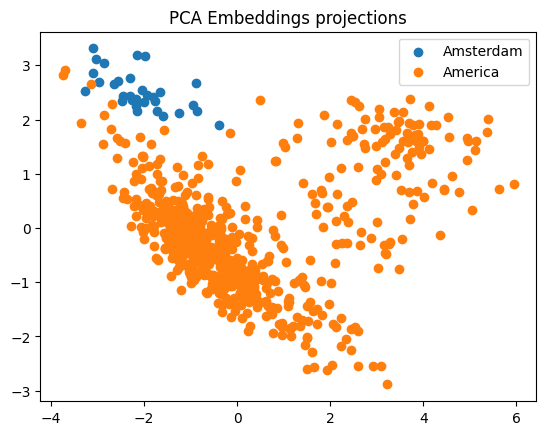

In [26]:
plt.scatter(X_pca[:len(embeddings1),0], X_pca[:len(embeddings1),1], label=TERM1)
plt.scatter(X_pca[len(embeddings1):,0], X_pca[len(embeddings1):,1], label=TERM2)
plt.legend()
plt.title("PCA Embeddings projections")

### UMAP

In [27]:
import umap

X_umap = umap.UMAP().fit_transform(all_embeddings)

Text(0.5, 1.0, 'UMAP Embeddings projections')

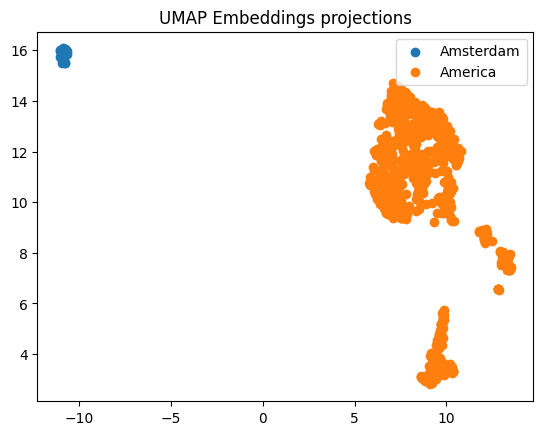

In [28]:
plt.scatter(X_umap[:len(embeddings1),0], X_umap[:len(embeddings1),1], label=TERM1)
plt.scatter(X_umap[len(embeddings1):,0], X_umap[len(embeddings1):,1], label=TERM2)
plt.legend()
plt.title("UMAP Embeddings projections")